In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
print ("pandas version:  {}".format(pd.__version__))
import time
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation, record_evaluation
print("LightGBM version:  {}".format(lgb.__version__))

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

pandas version:  2.0.3
LightGBM version:  3.3.2
/kaggle/input/storesalestfs-featureenigneering/__results__.html
/kaggle/input/storesalestfs-featureenigneering/__notebook__.ipynb
/kaggle/input/storesalestfs-featureenigneering/__output__.json
/kaggle/input/storesalestfs-featureenigneering/train_features.csv
/kaggle/input/storesalestfs-featureenigneering/test_features.csv
/kaggle/input/storesalestfs-featureenigneering/custom.css
/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


The goal of this competition is to predict daily sales based on date, store number, item category (aka family). Additionally, information about the stores (regions & types), about holidays and the oil price during the whole time period (train+test) is available. 

This notebook is used for modelling. The data is prepared in a separate notebook.

In [2]:
# read the output file of the prepare data notebook here
train = pd.read_csv('/kaggle/input/storesalestfs-featureenigneering/train_features.csv')
test = pd.read_csv('/kaggle/input/storesalestfs-featureenigneering/test_features.csv')
# and sample submission
sample_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

In [3]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,...,c_sales_std,is_onpromotion,op_sales_median,op_sales_mean,op_sales_min,op_sales_max,dcoilwtico,is_national_hol,is_local_hol,is_holiday
0,648648,2014-01-01,1,AUTOMOTIVE,0.0,0,2014,1,1,2,...,6.250549,0,3.0,3.542113,0.0,19.0,98.17,True,False,True
1,648649,2014-01-01,1,BABY CARE,0.0,0,2014,1,1,2,...,0.766963,0,0.0,0.000000,0.0,0.0,98.17,True,False,True
2,648650,2014-01-01,1,BEAUTY,0.0,0,2014,1,1,2,...,5.110346,0,2.0,2.263397,0.0,11.0,98.17,True,False,True
3,648651,2014-01-01,1,BEVERAGES,0.0,0,2014,1,1,2,...,2431.441640,0,1093.0,1266.943522,0.0,3366.0,98.17,True,False,True
4,648652,2014-01-01,1,BOOKS,0.0,0,2014,1,1,2,...,0.618165,0,0.0,0.159848,0.0,8.0,98.17,True,False,True


In [4]:
test.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,...,c_sales_std,is_onpromotion,op_sales_median,op_sales_mean,op_sales_min,op_sales_max,dcoilwtico,is_national_hol,is_local_hol,is_holiday
0,3000888,2017-08-16,1,AUTOMOTIVE,0.0,0,2017,8,16,2,...,6.250549,0,3.0,3.542113,0.0,19.0,46.8,False,False,False
1,3000889,2017-08-16,1,BABY CARE,0.0,0,2017,8,16,2,...,0.766963,0,0.0,0.000000,0.0,0.0,46.8,False,False,False
2,3000890,2017-08-16,1,BEAUTY,0.0,2,2017,8,16,2,...,5.110346,1,4.0,4.173516,1.0,12.0,46.8,False,False,False
3,3000891,2017-08-16,1,BEVERAGES,0.0,20,2017,8,16,2,...,2431.441640,1,2097.0,1942.677134,325.0,5051.0,46.8,False,False,False
4,3000892,2017-08-16,1,BOOKS,0.0,0,2017,8,16,2,...,0.618165,0,0.0,0.159848,0.0,8.0,46.8,False,False,False


In [5]:
# append train and test temporarily
train = pd.concat( [train,test])

In [6]:
train.dtypes

id                     int64
date                  object
store_nbr              int64
family                object
sales                float64
onpromotion            int64
year                   int64
month                  int64
day                    int64
dayofweek              int64
dayofyear              int64
weekofyear             int64
is_weekend              bool
weekIdContinous        int64
sales_lag2w          float64
sales_lag4w          float64
sales_lag8w          float64
sales_lag1y          float64
is_payday              int64
sf_monthly_mean      float64
sf_yearly_mean       float64
s_sales_median       float64
s_sales_mean         float64
s_sales_max          float64
s_sales_std          float64
city                  object
state                 object
type                  object
cluster                int64
transactions_mean    float64
transactions_std     float64
st_ratio             float64
c_sales_median       float64
c_sales_mean         float64
c_sales_max   

In [7]:
train.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
year                 0
month                0
day                  0
dayofweek            0
dayofyear            0
weekofyear           0
is_weekend           0
weekIdContinous      0
sales_lag2w          0
sales_lag4w          0
sales_lag8w          0
sales_lag1y          0
is_payday            0
sf_monthly_mean      0
sf_yearly_mean       0
s_sales_median       0
s_sales_mean         0
s_sales_max          0
s_sales_std          0
city                 0
state                0
type                 0
cluster              0
transactions_mean    0
transactions_std     0
st_ratio             0
c_sales_median       0
c_sales_mean         0
c_sales_max          0
c_sales_std          0
is_onpromotion       0
op_sales_median      0
op_sales_mean        0
op_sales_min         0
op_sales_max         0
dcoilwtico           0
is_national_hol      0
is_local_ho

# Label Encoding

In [8]:
# convert text columns to numbers, lightGBM want numbers! 
label_encoder = LabelEncoder()

train.city = label_encoder.fit_transform(train.city)
train.state = label_encoder.fit_transform(train.state)
train.cluster = label_encoder.fit_transform(train.cluster)
train.type = label_encoder.fit_transform(train.type)
train.family = label_encoder.fit_transform(train.family)
train.is_national_hol = label_encoder.fit_transform(train.is_national_hol)
train.is_local_hol = label_encoder.fit_transform(train.is_local_hol)
train.is_holiday = label_encoder.fit_transform(train.is_holiday)
train.is_weekend = label_encoder.fit_transform(train.is_weekend)
train.dtypes

id                     int64
date                  object
store_nbr              int64
family                 int64
sales                float64
onpromotion            int64
year                   int64
month                  int64
day                    int64
dayofweek              int64
dayofyear              int64
weekofyear             int64
is_weekend             int64
weekIdContinous        int64
sales_lag2w          float64
sales_lag4w          float64
sales_lag8w          float64
sales_lag1y          float64
is_payday              int64
sf_monthly_mean      float64
sf_yearly_mean       float64
s_sales_median       float64
s_sales_mean         float64
s_sales_max          float64
s_sales_std          float64
city                   int64
state                  int64
type                   int64
cluster                int64
transactions_mean    float64
transactions_std     float64
st_ratio             float64
c_sales_median       float64
c_sales_mean         float64
c_sales_max   

# Reduce Data Size

In [9]:
# convert whole numbers to smaller data type 
train.store_nbr = train.store_nbr.astype('int8')
train.month = train.month.astype('int8')
train.day = train.day.astype('int8')
train.weekofyear = train.weekofyear.astype('int8')
train.dayofyear = train.dayofyear.astype('int16')
train.year = train.year.astype('int16')
train.family = train.family.astype('int8')
train.onpromotion = train.onpromotion.astype('int16')
train.is_onpromotion = train.is_onpromotion.astype('int8')
train.dayofweek = train.dayofweek.astype('int8')
train.city = train.city.astype('int8')
train.state = train.state.astype('int8')
train.type = train.type.astype('int8')
train.cluster = train.cluster.astype('int8')
train.is_national_hol = train.is_national_hol.astype('int8')
train.is_local_hol = train.is_local_hol.astype('int8')
train.is_holiday = train.is_holiday.astype('int8')
train.is_weekend = train.is_weekend.astype('int8')
train.is_payday = train.is_payday.astype('int8')
train.dcoilwtico = train.dcoilwtico.astype('float32')

In [10]:
train.dtypes

id                     int64
date                  object
store_nbr               int8
family                  int8
sales                float64
onpromotion            int16
year                   int16
month                   int8
day                     int8
dayofweek               int8
dayofyear              int16
weekofyear              int8
is_weekend              int8
weekIdContinous        int64
sales_lag2w          float64
sales_lag4w          float64
sales_lag8w          float64
sales_lag1y          float64
is_payday               int8
sf_monthly_mean      float64
sf_yearly_mean       float64
s_sales_median       float64
s_sales_mean         float64
s_sales_max          float64
s_sales_std          float64
city                    int8
state                   int8
type                    int8
cluster                 int8
transactions_mean    float64
transactions_std     float64
st_ratio             float64
c_sales_median       float64
c_sales_mean         float64
c_sales_max   

In [11]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,...,c_sales_std,is_onpromotion,op_sales_median,op_sales_mean,op_sales_min,op_sales_max,dcoilwtico,is_national_hol,is_local_hol,is_holiday
0,648648,2014-01-01,1,0,0.0,0,2014,1,1,2,...,6.250549,0,3.0,3.542113,0.0,19.0,98.169998,1,0,1
1,648649,2014-01-01,1,1,0.0,0,2014,1,1,2,...,0.766963,0,0.0,0.000000,0.0,0.0,98.169998,1,0,1
2,648650,2014-01-01,1,2,0.0,0,2014,1,1,2,...,5.110346,0,2.0,2.263397,0.0,11.0,98.169998,1,0,1
3,648651,2014-01-01,1,3,0.0,0,2014,1,1,2,...,2431.441640,0,1093.0,1266.943522,0.0,3366.0,98.169998,1,0,1
4,648652,2014-01-01,1,4,0.0,0,2014,1,1,2,...,0.618165,0,0.0,0.159848,0.0,8.0,98.169998,1,0,1


In [12]:
# split train and test again
test = train.loc[train.id >= 3000888]
test.shape

(28512, 45)

In [13]:
train = train.loc[train.id < 3000888]
train.shape

(2361414, 45)

# Modelling

In [14]:
columns_to_drop = ['sales','id','date','is_national_hol','is_local_hol']

In [15]:
# create validation set based on time, I use 2 weeks because the test set is 2 weeks
#train.date.max()
X_train = train.loc[train.date < '2017-08-01']
X_train.tail()
y_train = X_train.sales
X_train = X_train.drop(columns_to_drop, axis = 1)
X_val = train.loc[train.date >= '2017-08-01']
y_val = X_val.sales
X_val = X_val.drop(columns_to_drop, axis = 1)

In [16]:
X_val.head()

,store_nbr,family,onpromotion,year,month,day,dayofweek,dayofyear,weekofyear,is_weekend,...,c_sales_mean,c_sales_max,c_sales_std,is_onpromotion,op_sales_median,op_sales_mean,op_sales_min,op_sales_max,dcoilwtico,is_holiday
2334684,1,0,0,2017,8,1,1,213,31,0,...,6.491400,255.0,6.250549,0,3.0,3.542113,0.0,19.0,49.189999,0
2334685,1,1,0,2017,8,1,1,213,31,0,...,0.141260,116.0,0.766963,0,0.0,0.000000,0.0,0.0,49.189999,0
2334686,1,2,0,2017,8,1,1,213,31,0,...,4.076740,136.0,5.110346,0,2.0,2.263397,0.0,11.0,49.189999,0
2334687,1,3,26,2017,8,1,1,213,31,0,...,2738.754588,25413.0,2431.441640,1,2097.0,1942.677134,325.0,5051.0,49.189999,0
2334688,1,4,0,2017,8,1,1,213,31,0,...,0.090614,51.0,0.618165,0,0.0,0.159848,0.0,8.0,49.189999,0


In [17]:
X_train.head()

,store_nbr,family,onpromotion,year,month,day,dayofweek,dayofyear,weekofyear,is_weekend,...,c_sales_mean,c_sales_max,c_sales_std,is_onpromotion,op_sales_median,op_sales_mean,op_sales_min,op_sales_max,dcoilwtico,is_holiday
0,1,0,0,2014,1,1,2,1,1,0,...,6.491400,255.0,6.250549,0,3.0,3.542113,0.0,19.0,98.169998,1
1,1,1,0,2014,1,1,2,1,1,0,...,0.141260,116.0,0.766963,0,0.0,0.000000,0.0,0.0,98.169998,1
2,1,2,0,2014,1,1,2,1,1,0,...,4.076740,136.0,5.110346,0,2.0,2.263397,0.0,11.0,98.169998,1
3,1,3,0,2014,1,1,2,1,1,0,...,2738.754588,25413.0,2431.441640,0,1093.0,1266.943522,0.0,3366.0,98.169998,1
4,1,4,0,2014,1,1,2,1,1,0,...,0.090614,51.0,0.618165,0,0.0,0.159848,0.0,8.0,98.169998,1


# Model - 2. lgbm with rsmle 
in previous versions of this notebook I tried LGBM with RSME as error metric, because it does not support RSMLE per se.
2 different approaches to use RMSLE nevertheless.

1. write custom eval function

thanks to: https://stackoverflow.com/questions/61630331/early-stopping-for-lightgbm-not-working-when-rmsle-is-the-eval-metric (could not get this working)

2. log-transform the target, use RSME and transform the predictions back

thanks to: https://github.com/microsoft/LightGBM/issues/4886

In [18]:
# like this
df=pd.DataFrame({'yhat': [5000,2500,500], 'y': [10000,5000,1000]})
df['lny'] = np.log1p(df.y)
df['transformback'] = np.expm1(df.lny)
df

,yhat,y,lny,transformback
0,5000,10000,9.210440,10000.0
1,2500,5000,8.517393,5000.0
2,500,1000,6.908755,1000.0


In [19]:
categorical_columns = ['store_nbr', 'cluster' , 'type', 'city', 'state' , 'family']

In [20]:
# create lgbm datasets
dtrain = lgb.Dataset(X_train, label=np.log1p(y_train), categorical_feature = categorical_columns)
dval = lgb.Dataset(X_val, label=np.log1p(y_val), categorical_feature = categorical_columns)

In [21]:
# light gbm parameters
lgb_params = {'objective': 'regression',
    'metric': 'RMSE',
    'boosting_type': 'gbdt',
    'num_iterations': 1000,
    'learning_rate': 0.09705467290117309, 
    'num_leaves': 899, 
    'subsample': 0.14538536276241876, 
    'colsample_bytree': 0.99582859725253, 
    'min_data_in_leaf': 10
             }

In [22]:
ts = time.time()

metric_over_time = {} # dict for logging the evaluation metrics

model = lgb.train(        
        lgb_params, 
        dtrain, 
        valid_sets=[dtrain, dval],
        valid_names=['train','val'],
        callbacks=[early_stopping(100), log_evaluation(100), record_evaluation(metric_over_time)]
    )


execution_time = time.time() - ts
print("\nTraining time: " + str(round(execution_time,3)) + "s")

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.987126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4121
[LightGBM] [Info] Number of data points in the train set: 2334684, number of used features: 40
[LightGBM] [Info] Start training from score 3.134631


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.330688	val's rmse: 0.375533
[200]	train's rmse: 0.312491	val's rmse: 0.374162
[300]	train's rmse: 0.299203	val's rmse: 0.374244
Early stopping, best iteration is:
[236]	train's rmse: 0.307294	val's rmse: 0.373884

Training time: 240.82s


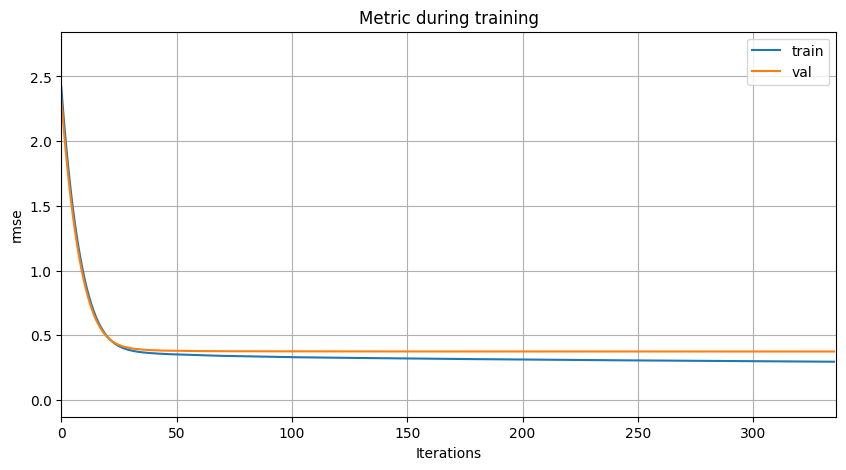

In [23]:
lgb.plot_metric(metric_over_time, figsize=(10,5))
plt.show()

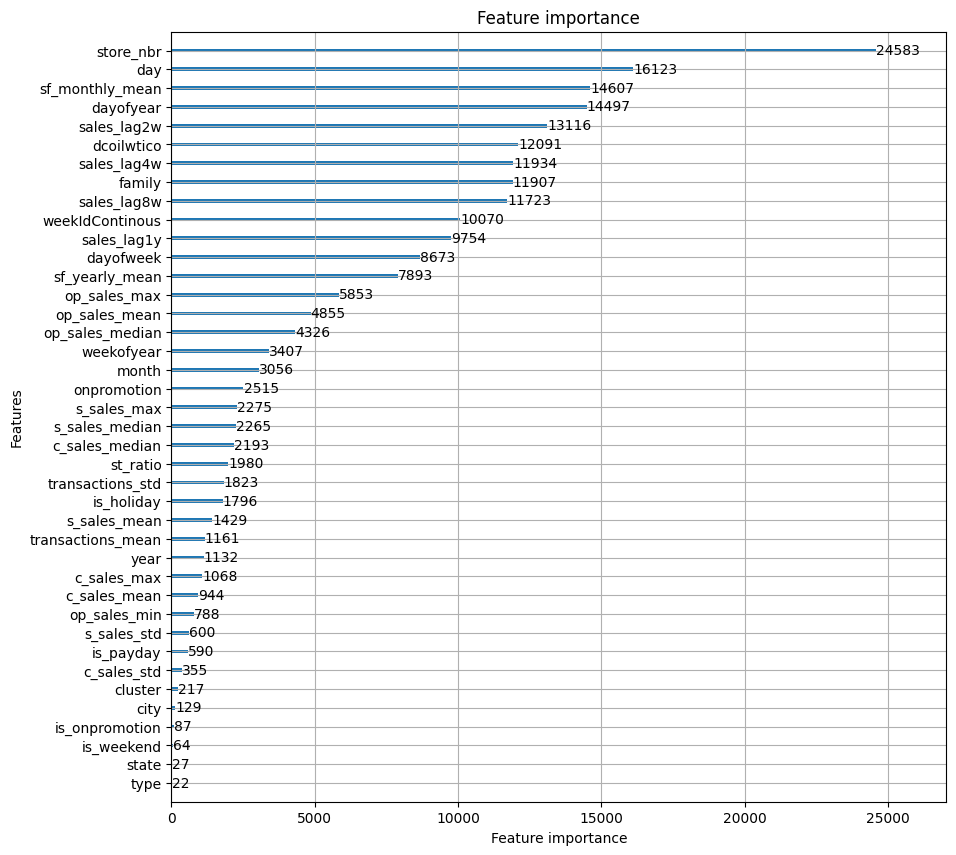

In [24]:
lgb.plot_importance(model, figsize=(10,10))
plt.show()

In [25]:
# go again without specifying categorical features, not again, gave worse results, see previous versions
#dtrain = lgb.Dataset(X_train, label=y_train)
#dval = lgb.Dataset(X_val, label=y_val)

In [26]:
# retrain on whole training data
# create lgbm datasets
dtrain = lgb.Dataset(train.drop(columns_to_drop, axis = 1), label=np.log1p(train.sales), categorical_feature = categorical_columns)
ts = time.time()


model = lgb.train(        
        lgb_params, 
        dtrain
    )


execution_time = time.time() - ts
print("\nTraining time: " + str(round(execution_time,3)) + "s")

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.866795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4124
[LightGBM] [Info] Number of data points in the train set: 2361414, number of used features: 40
[LightGBM] [Info] Start training from score 3.140228

Training time: 557.453s


In [27]:
X_test = test.drop(columns_to_drop, axis = 1)

In [28]:
preds = np.expm1(model.predict(X_test, num_iteration=model.best_iteration)) # transform predictions back immediatelly


In [29]:
preds.min()

-0.19959759218343567

In [30]:
preds.max()

14771.915355032339

In [31]:
# clip negative values and set a max to the predictions
preds=preds.clip(0,60000)

In [32]:
train.sales.min()

0.0

In [33]:
train.sales.max()

124717.0

# Postprocessing

Not all stores sell all categories/families of items. Set all those predicitions to 0.

In [34]:
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')

In [35]:
submission_pre = pd.DataFrame(data={"id" : sample_submission.id,
                                   "preds" : preds})

In [36]:
submission_pre = pd.merge(test,submission_pre, on='id',how='left')

In [37]:
submission_pre.head()

,id,date,store_nbr,family,onpromotion,preds
0,3000888,2017-08-16,1,AUTOMOTIVE,0,5.364986
1,3000889,2017-08-16,1,BABY CARE,0,0.023176
2,3000890,2017-08-16,1,BEAUTY,2,5.516083
3,3000891,2017-08-16,1,BEVERAGES,20,2516.829172
4,3000892,2017-08-16,1,BOOKS,0,0.021164


In [38]:
# get info about which stores have 0 sales for which categories out of train
store_info=train[['store_nbr','family','sales']].groupby(['store_nbr','family']).sum().reset_index()
store_info = store_info.loc[store_info.sales == 0] #reduce to those without sales
store_info.head()

,store_nbr,family,sales
1,1,BABY CARE,0.0
268,9,BOOKS,0.0
301,10,BOOKS,0.0
334,11,BOOKS,0.0
367,12,BOOKS,0.0


In [39]:
categories_not_sold_in_all_stores = store_info.family.unique()
categories_not_sold_in_all_stores

array(['BABY CARE', 'BOOKS', 'LAWN AND GARDEN', 'LADIESWEAR'],
      dtype=object)

In [40]:
# set all predictions to 0 for the categories that are not sold in certain stores
for cat in categories_not_sold_in_all_stores:
    category = cat
    stores_that_dont_sell_category = list(store_info.loc[(store_info.family == category)].store_nbr)
    submission_pre.loc[submission_pre.store_nbr.isin(stores_that_dont_sell_category) & (submission_pre.family==category),['preds']] = 0

In [41]:
submission_pre.head()

,id,date,store_nbr,family,onpromotion,preds
0,3000888,2017-08-16,1,AUTOMOTIVE,0,5.364986
1,3000889,2017-08-16,1,BABY CARE,0,0.000000
2,3000890,2017-08-16,1,BEAUTY,2,5.516083
3,3000891,2017-08-16,1,BEVERAGES,20,2516.829172
4,3000892,2017-08-16,1,BOOKS,0,0.021164


# Submission

In [42]:
sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [43]:
# generate submission file 
submission = submission_pre[['id','preds']]
submission = submission.rename(columns={'preds':'sales'})

submission.to_csv('submission.csv', index=False)
submission.head()

,id,sales
0,3000888,5.364986
1,3000889,0.000000
2,3000890,5.516083
3,3000891,2516.829172
4,3000892,0.021164
